In [1]:
import torch
import numpy as np
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
from torchvision import datasets
import scipy.stats as stats 
import matplotlib.pyplot as plt
import utils.metrics as metrics

pred_dict = {}

predictions_r9_fm = torch.load('data\predictions_example\prediction_dict_res9_fmnist.pt', map_location=torch.device('cpu'))
predictions_r9_fm_lla = torch.load('data\predictions_example\prediction_dict_res9_fmnist_lla.pt', map_location=torch.device('cpu'))

predictions_r9_cifar = torch.load('data\predictions_example\prediction_dict_res9_cifar.pt', map_location=torch.device('cpu'))
predictions_r9_cifar_lla = torch.load('data\predictions_example\prediction_dict_res9_cifar_lla.pt', map_location=torch.device('cpu'))

predictions_r50_cifar = torch.load('data\predictions_example\prediction_dict_res50_cifar.pt', map_location=torch.device('cpu'))
predictions_r50_cifar_lla = torch.load('data\predictions_example\prediction_dict_res50_cifar_lla.pt', map_location=torch.device('cpu'))

test_data_fm = datasets.FashionMNIST(
    root="data/FashionMNIST",
    train=False,
    download=True,
    transform=ToTensor()
)

ood_test_data_fm = datasets.MNIST(
    root="data/MNIST",
    train=False,
    download=True,
    transform=ToTensor()
) 

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

test_data_cifar = datasets.CIFAR10(
    root="data/CIFAR10",
    train=False,
    download=True,
    transform=transform_test
)

ood_test_data_cifar = datasets.CIFAR100(
    root="data/CIFAR100",
    train=False,
    download=True,
    transform=transform_test
) 

C:\Users\s4531973\AppData\Local\Temp\ipykernel_6128\1413713720.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  predictions_r9_fm = torch.load('data\predictions_example\

Files already downloaded and verified
Files already downloaded and verified


In [12]:
name_dict = {'ntkuq': 'NUQLs',
             'NTK-UQ-Linear': 'NUQLs',
             'NUQLs': 'NUQLs',
             'eNUQLs': 'eNUQLs',
             'de': 'DE',
             'DE': 'DE',
             'SWAG': 'SWAG',
             'swag': 'SWAG',
             'mc': 'MC',
             'MC-Dropout': 'MC',
             'LLA-LL-KFAC': 'LLA'}

In [13]:
def sort_probabilies(predictions,test_data, predictions_lla=None):
    prob_var_dict = {}
    for m in predictions.keys():
        pi_correct, pi_incorrect = metrics.sort_preds(predictions[m]['id'],torch.tensor(test_data.targets))
            
        max_index = pi_correct.mean(0).argmax(1)
        pi_correct_var = pi_correct[:,range(len(max_index)),max_index].var(0)

        max_index = pi_incorrect.mean(0).argmax(1)
        pi_incorrect_var = pi_incorrect[:,range(len(max_index)),max_index].var(0)

        max_index = predictions[m]['ood'].mean(0).argmax(1)
        po_var = predictions[m]['ood'][:,range(len(max_index)),max_index].var(0)

        prob_var_dict[name_dict[m]] = {'id_correct': pi_correct_var,
                        'id_incorrect': pi_incorrect_var,
                        'ood': po_var}
    if predictions_lla is not None:
        for m in predictions_lla.keys():
            if m == 'LLA-LL-KFAC':
                pi_correct, pi_incorrect = metrics.sort_preds(predictions_lla[m]['id'],torch.tensor(test_data.targets))
                
                max_index = pi_correct.mean(0).argmax(1)
                pi_correct_var = pi_correct[:,range(len(max_index)),max_index].var(0)

                max_index = pi_incorrect.mean(0).argmax(1)
                pi_incorrect_var = pi_incorrect[:,range(len(max_index)),max_index].var(0)

                max_index = predictions_lla[m]['ood'].mean(0).argmax(1)
                po_var = predictions_lla[m]['ood'][:,range(len(max_index)),max_index].var(0)

                prob_var_dict[name_dict[m]] = {'id_correct': pi_correct_var,
                                'id_incorrect': pi_incorrect_var,
                                'ood': po_var}
    return prob_var_dict

def add_baseline(prob_var_dict,test_data,ood_test_data):
    ## Add baseline method    
    S = 10
    scale_n = 1
    scale_d = 0.1
    base_method = torch.distributions.dirichlet.Dirichlet(torch.tensor([scale_d]*10))
    sample = base_method.sample(torch.Size([S,len(torch.tensor(test_data.targets))]))
    sample_ood = base_method.sample(torch.Size([S,len(torch.tensor(ood_test_data.targets))]))

    sample = (torch.randn((S,len(torch.tensor(test_data.targets)),10)) * scale_n).softmax(2)
    sample_ood = (torch.randn((S,len(torch.tensor(test_data.targets)),10)) * scale_n).softmax(2)

    sample_mean = sample.mean(0).argmax(1)

    pi_correct, pi_incorrect = metrics.sort_preds(sample,torch.tensor(test_data.targets))

    max_index = pi_correct.mean(0).argmax(1)
    pi_correct_var = pi_correct[:,range(len(max_index)),max_index].var(0)

    max_index = pi_incorrect.mean(0).argmax(1)
    pi_incorrect_var = pi_incorrect[:,range(len(max_index)),max_index].var(0)

    max_index = sample_ood.mean(0).argmax(1)
    po_var = sample_ood[:,range(len(max_index)),max_index].var(0)

    prob_var_dict['BASE'] = {'id_correct': pi_correct_var,
                        'id_incorrect': pi_incorrect_var,
                        'ood': po_var}
    return prob_var_dict

def skew_median(prob_var_dict):
    for m in prob_var_dict.keys():
        print(f'method = {m}')

        idc = prob_var_dict[m]['id_correct']
        idic = prob_var_dict[m]['id_incorrect']
        ood = prob_var_dict[m]['ood']

        # Skewness measurement
        ids = stats.skew(idc.numpy())
        idics = stats.skew(idic.numpy())
        oods = stats.skew(ood.numpy())
        print(f'sample skew: id_correct = {ids:.3}, id_incorrect = {idics:.3}, ood = {oods:.3}')

        pfm_id = (idc.mean() - stats.mode(idc)[0]) / idc.std()
        pfm_idic = (idic.mean() - stats.mode(idic)[0]) / idic.std()
        pfm_ood = (ood.mean() - stats.mode(ood)[0]) / ood.std()
        print(f'pearsons first moment: id_correct = {pfm_id:.3}, id_incorrect = {pfm_idic:.3}, ood = {pfm_ood:.3}')
        
        psm_id = 3*(idc.mean() - idc.median()) / idc.std()
        psm_idic = 3*(idic.mean() - idic.median()) / idic.std()
        psm_ood = 3*(ood.mean() - ood.median()) / ood.std()
        print(f'pearsons second moment: id skew = {psm_id:.3}, id skew = {psm_idic:.3}, ood_skew = {psm_ood:.3}')

        id_correct_med = idc.median()
        id_incorrect_med = idic.median()
        ood_med = ood.median()
        
        print(f'median id_correct = {id_correct_med:.3}, id_incorrect = {id_incorrect_med:.3}, ood = {ood_med:.3}, |diff| (ood-id_c) = {torch.abs(ood_med - id_correct_med):.3}\n')

In [14]:
def array_to_numpy(x):
    if torch.is_tensor(x):
        return x.detach().cpu().numpy()
    elif isinstance(x, np.ndarray):
        return x
    else:
        return 'ERR'

def ax_violin(ax,var_dict,set_sigma=False, legend_true=False, fs = 12, title=None):
    ticks = list(var_dict.keys())
    
    id_correct_var_list = []
    id_incorrect_var_list = []
    ood_var_list = []
    for key in var_dict.keys():
        pi_correct = array_to_numpy(var_dict[key]['id_correct'])
        pi_incorrect = array_to_numpy(var_dict[key]['id_incorrect'])
        po = array_to_numpy(var_dict[key]['ood'])

        id_correct_var_list.append(pi_correct.tolist())
        id_incorrect_var_list.append(pi_incorrect.tolist())
        ood_var_list.append(po.tolist())

    id_vars_plot = ax.violinplot(id_correct_var_list,
                                positions=np.array(
        np.arange(len(id_correct_var_list)))*2-0.6, 
                                points=1000, widths=0.6,
                     showmeans=False, showextrema=False, showmedians=True)
    id_vars_plot_2 = ax.violinplot(id_incorrect_var_list,
                                positions=np.array(
        np.arange(len(id_incorrect_var_list)))*2, 
                                points=1000, widths=0.6,
                     showmeans=False, showextrema=False, showmedians=True)
    ood_vars_plot = ax.violinplot(ood_var_list,
                                positions=np.array(
        np.arange(len(ood_var_list)))*2+0.6,
                                points=1000, widths=0.6,
                     showmeans=False, showextrema=False, showmedians=True)
    
    for pc in id_vars_plot['bodies']:
        # pc.set_facecolor('#D43F3A')
        pc.set_edgecolor('black')
        pc.set_alpha(0.4)

    for pc in id_vars_plot_2['bodies']:
        # pc.set_facecolor('#D43F3A')
        pc.set_edgecolor('black')
        pc.set_alpha(0.4)

    for pc in ood_vars_plot['bodies']:
        # pc.set_facecolor('#D43F3A')
        pc.set_edgecolor('black')
        pc.set_alpha(0.4)
    

    def define_box_properties(plot_name, color_code, label):
        for k, v in plot_name.items():
            plt.setp(plot_name.get(k), color=color_code)

        if legend_true:    
            # use plot function to draw a small line to name the legend.
            plt.plot([], c=color_code, label=label)
            plt.legend(fontsize=fs)
    
    # # setting colors for each groups
    define_box_properties(id_vars_plot, '#008000', 'ID Correct')
    define_box_properties(id_vars_plot_2, '#D7191C', 'ID Incorrect')
    define_box_properties(ood_vars_plot, '#2C7BB6', 'OOD')
    
    ax.set_xticks(np.arange(0, len(ticks) * 2, 2), ticks)
    ax.set_xlim(-1.2, len(ticks)*2 - 0.8)
    if set_sigma:
        ax.set_ylabel('$\sigma^2$', fontsize=fs)
    ax.tick_params(labelsize=fs)

    if title is not None:
        ax.set_title(title, fontsize=fs)

In [15]:
pvd_r9_fm = sort_probabilies(predictions_r9_fm,test_data_fm,predictions_r9_fm_lla)
pvd_r9_fm = add_baseline(pvd_r9_fm,ood_test_data_fm,test_data_fm)

pvd_r9_cifar = sort_probabilies(predictions_r9_cifar,test_data_cifar,predictions_r9_cifar_lla)
pvd_r9_cifar = add_baseline(pvd_r9_cifar,ood_test_data_cifar,test_data_cifar)

pvd_r50_cifar = sort_probabilies(predictions_r50_cifar,test_data_cifar,predictions_r50_cifar_lla)
pvd_r50_cifar = add_baseline(pvd_r50_cifar,ood_test_data_cifar,test_data_cifar)

C:\Users\s4531973\AppData\Local\Temp\ipykernel_15612\4269441827.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pi_correct, pi_incorrect = metrics.sort_preds(predictions[m]['id'],torch.tensor(test_data.targets))
C:\Users\s4531973\AppData\Local\Temp\ipykernel_15612\4269441827.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pi_correct, pi_incorrect = metrics.sort_preds(predictions_lla[m]['id'],torch.tensor(test_data.targets))
C:\Users\s4531973\AppData\Local\Temp\ipykernel_15612\4269441827.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceT

C:\Users\s4531973\AppData\Local\Temp\ipykernel_15612\1413919290.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


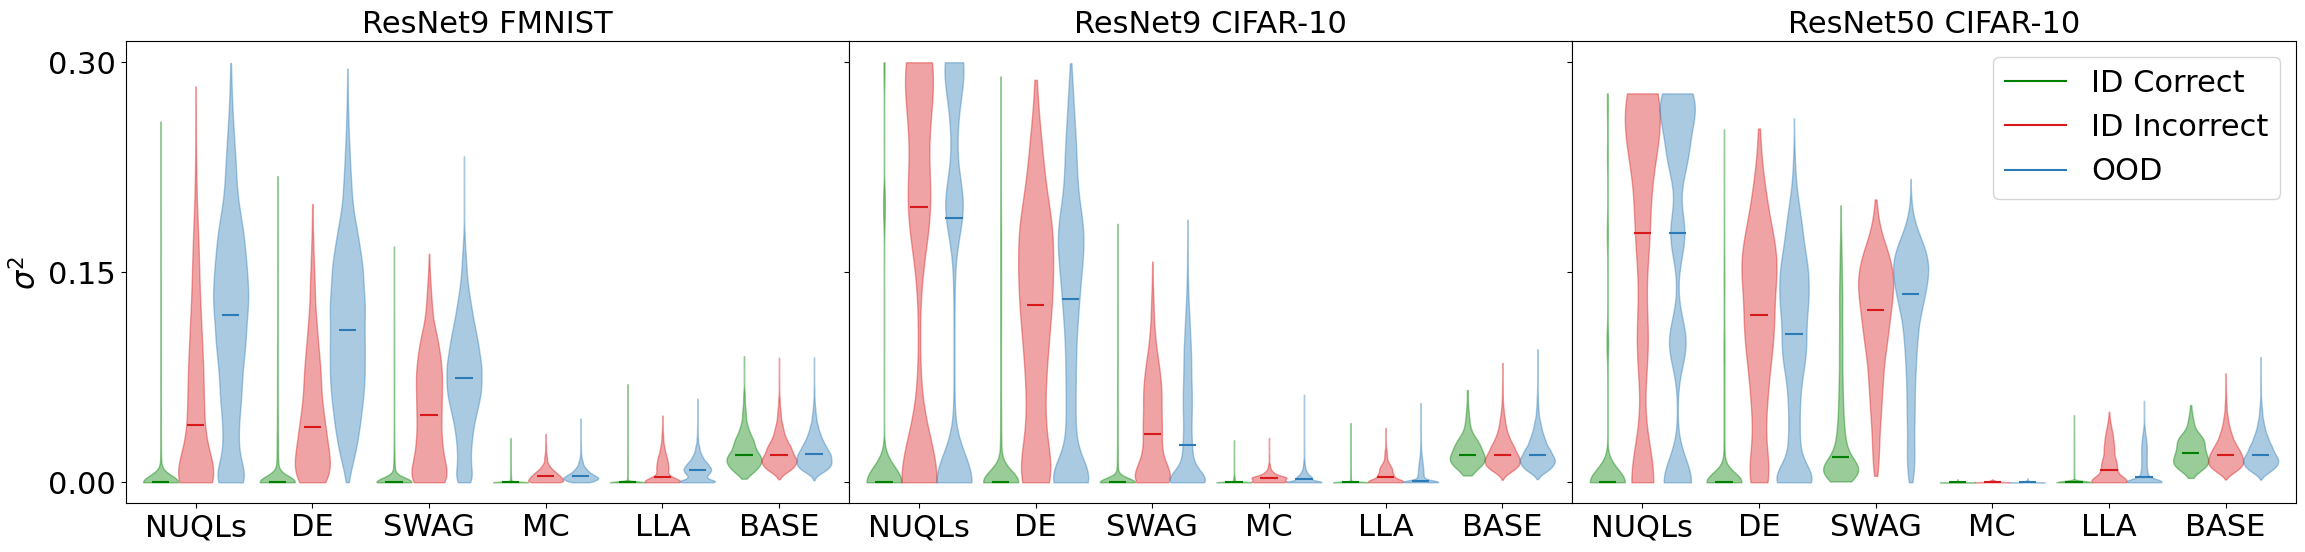

In [16]:
w, h, fs = 28, 6, 22
fig, (ax1,ax2,ax3) = plt.subplots(1,3,facecolor='white', figsize = (1*w,1*h), sharey=True)
fig.subplots_adjust(wspace=0)
ax_violin(ax1,pvd_r9_fm, set_sigma=True, fs=fs, title='ResNet9 FMNIST')
ax_violin(ax2,pvd_r9_cifar, fs=fs, title='ResNet9 CIFAR-10')
ax_violin(ax3,pvd_r50_cifar, legend_true=True, fs=fs, title='ResNet50 CIFAR-10')
ax1.set_yticks(np.array((0,0.15,0.3)))

fig.show()
fig.savefig('violin_plot_uncertainty.pdf',format='pdf',bbox_inches='tight')
